###  Import libraries


In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Hiperparámetros

In [2]:
csv_path          = "regina.csv"
dropped_features  = ['Hi Temp', 'Low Temp', 'Wind Chill', 'Heat Index', 'THSW Index', 'THW Index', 'Wind Run', 'Solar Energy', 'Hi Solar Rad.', 'In Heat', 'ISS Recept', 'Arc. Int']

train_perc = .9

sequence_length = 90
offset          = 0
sampling_rate   = 1
length          = 6 #horas
min_temp        = 0
batch_size      = 256

learning_rate   = 0.001
epochs          = 1
loss            = "mse"

### Read CSV

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d.%m.%y %H:%M')

wind_dic = {'---' : 0,
            'E': 1,
            'W': 2,
            'N': 3,
            'S': 4,
            'NE': 5,
            'SE': 6,
            'NW': 7,
            'SW': 8,
            'ENE': 9,
            'NNE': 10,
            'WNW': 11,
            'NNW': 12,
            'ESE': 13,
            'SSE': 14,
            'WSW': 15,
            'SSW': 16}

data = pd.read_csv(csv_path, parse_dates=['Date Time'], date_parser=dateparse, na_values=['---', '------'], converters={'Wind Dir': lambda x: wind_dic[x], 'Hi Dir': lambda x: wind_dic[x]}, index_col=0)

### Agregamos los datos que faltan

In [4]:
data['Temp Out'] = data['Temp Out'].apply(lambda x: x-2)

data = data.resample('10min', origin='start').mean()

data['Wind Dir'] = data['Wind Dir'].replace(np.nan, 0)
data['Hi Dir'] = data['Hi Dir'].replace(np.nan, 0)

data = data.interpolate()

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 627179 entries, 2010-01-28 14:20:00 to 2022-01-01 00:00:00
Freq: 10T
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Temp Out       627179 non-null  float64
 1   Hi Temp        627179 non-null  float64
 2   Low Temp       627179 non-null  float64
 3   Out Hum        627179 non-null  float64
 4   Dew Pt.        627179 non-null  float64
 5   Wind Speed     627179 non-null  float64
 6   Wind Dir       627179 non-null  float64
 7   Wind Run       627179 non-null  float64
 8   Hi Speed       627179 non-null  float64
 9   Hi Dir         627179 non-null  float64
 10  Wind Chill     627179 non-null  float64
 11  Heat Index     627179 non-null  float64
 12  THW Index      627179 non-null  float64
 13  THSW Index     622656 non-null  float64
 14  Bar            627179 non-null  float64
 15  Rain           627179 non-null  float64
 16  Rain Rate      627179 non-null

### Convertimos estampillas de tiempo todo a segundos

In [5]:
timestamp_s = data.index
timestamp_s = timestamp_s.map(pd.Timestamp.timestamp)

day = 24*60*60
year = 365.2425 * day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

## Correlación de los datos

In [6]:
data.corr()

,Temp Out,Hi Temp,Low Temp,Out Hum,Dew Pt.,Wind Speed,Wind Dir,Wind Run,Hi Speed,Hi Dir,...,In Heat,ET,Wind Samp,Wind Tx,ISS Recept,Arc. Int,Day sin,Day cos,Year sin,Year cos
Temp Out,1.000000,0.999594,0.997314,-0.618099,0.637838,0.205359,0.232999,0.205984,0.310930,0.235823,...,0.758795,0.195215,0.104162,-0.002965,0.104177,NaN,-0.435191,-0.210957,0.079282,0.646774
Hi Temp,0.999594,1.000000,0.995834,-0.618553,0.637439,0.203664,0.231939,0.204288,0.309187,0.234780,...,0.759106,0.195075,0.104440,-0.002983,0.104484,NaN,-0.435216,-0.211761,0.078910,0.647320
Low Temp,0.997314,0.995834,1.000000,-0.616361,0.635813,0.206264,0.233991,0.206885,0.311684,0.236768,...,0.756017,0.194955,0.103344,-0.002965,0.103364,NaN,-0.434265,-0.209511,0.079588,0.644029
Out Hum,-0.618099,-0.618553,-0.616361,1.000000,0.141228,-0.401745,-0.305096,-0.402432,-0.504793,-0.318324,...,-0.337264,-0.196010,0.022232,0.001619,0.014608,NaN,0.452333,0.227616,0.212676,-0.284088
Dew Pt.,0.637838,0.637439,0.635813,0.141228,1.000000,-0.120652,0.025540,-0.120465,-0.085600,0.014211,...,0.674090,0.057911,0.138790,-0.002530,0.131796,NaN,-0.116473,-0.056457,0.316065,0.570534
Wind Speed,0.205359,0.203664,0.206264,-0.401745,-0.120652,1.000000,0.318082,0.999991,0.918865,0.335477,...,-0.006695,0.134804,0.022525,-0.001167,0.040598,NaN,-0.213365,-0.239211,-0.106014,-0.009716
Wind Dir,0.232999,0.231939,0.233991,-0.305096,0.025540,0.318082,1.000000,0.318987,0.433014,0.709830,...,0.057501,0.099921,0.064045,-0.001784,0.078166,NaN,-0.125320,-0.225141,-0.029331,0.088961
Wind Run,0.205984,0.204288,0.206885,-0.402432,-0.120465,0.999991,0.318987,1.000000,0.919271,0.336315,...,-0.006427,0.135009,0.022511,-0.001170,0.040599,NaN,-0.213583,-0.239824,-0.106090,-0.009435
Hi Speed,0.310930,0.309187,0.311684,-0.504793,-0.085600,0.918865,0.433014,0.919271,1.000000,0.451702,...,0.082188,0.159157,0.057584,-0.001544,0.068617,NaN,-0.239475,-0.268736,-0.111438,0.087644
Hi Dir,0.235823,0.234780,0.236768,-0.318324,0.014211,0.335477,0.709830,0.336315,0.451702,1.000000,...,0.063142,0.100267,0.059237,-0.001771,0.075205,NaN,-0.124374,-0.215857,-0.030606,0.096731


## Dropeamos las características que no tienen correlación

In [7]:
df = data.drop(dropped_features, axis = 1)

### Normalización de los datos

In [8]:
df_length = len(df)

train_length = int(df_length*train_perc)

train_mean = df.values[:train_length].mean(axis=0)
train_std  = df.values[:train_length].std(axis=0)

df_norm = (df.values - train_mean) / train_std
df_norm = pd.DataFrame(df_norm)

### Dividimos los datos

In [9]:
train_df = df_norm[:train_length-1]
val_df   = df_norm[train_length:]

###  Create datasets

In [10]:
def create_y_lento(df_norm, start, end, length, min_temp):
    y_data = []
    
    for i in range(start, end):
        freeze = 0
        for j in range(i, i+length):
            if df_norm.iloc[j][predicted_feature] <= min_temp:
                freeze = 1
                break
        y_data.append(freeze)

    return y_data

In [11]:
def create_y(df, start, end, length, min_temp):
    y_data = np.arange(end-start)
    
    df_bool = df['Temp Out'][start:end+length] <= min_temp
        
    for i in range(0, end-start):
        y_data[i] = 1 if np.any(df_bool[i:i+length]) else 0

    return y_data

In [12]:
start = sequence_length*sampling_rate + offset*sampling_rate
end   = train_length + offset*sampling_rate

x_train = train_df
y_train = create_y(df, start, end, length*6, min_temp)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train.values,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=True,
    batch_size = batch_size
)

In [13]:
start = train_length + sequence_length*sampling_rate + offset*sampling_rate

x_val = val_df
y_val = create_y(df, start, df_length, length*6, min_temp)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val.values,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=False,
    batch_size = batch_size
)

### Creamos el modelo

In [14]:
for batch in dataset_train.take(1):
    x, y = batch
    
input_shape = x.shape[1], x.shape[2]

In [15]:
inputs = keras.layers.Input(input_shape)
lstm_layer = keras.layers.LSTM(32, return_sequences=True)(inputs)
lstm_layer2 = keras.layers.LSTM(32)(lstm_layer)
output = keras.layers.Dense(1, activation="sigmoid")(lstm_layer2)

model = keras.Model(inputs, output)
model.compile(keras.optimizers.Adam(learning_rate), loss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90, 23)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 90, 32)            7168      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 15,521
Trainable params: 15,521
Non-trainable params: 0
_________________________________________________________________


### Entrenamos el modelo

In [16]:
path_checkpoint = "model_test_regina.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_best_only=True,
)

history = model.fit(dataset_train, epochs = epochs, validation_data=dataset_val, callbacks = [es_callback, modelckpt_callback])

2205/2205 [==============================] - 173s 77ms/step - loss: 0.0335 - val_loss: 0.0249

Epoch 00001: val_loss improved from inf to 0.02485, saving model to model_test_regina.h5


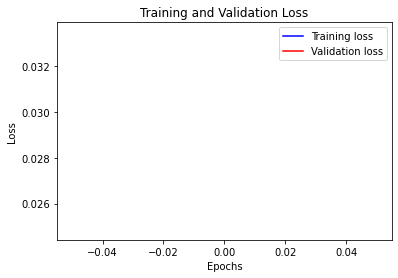

In [17]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

### Mostramos los resultados

1.192706850560197
tf.Tensor(1.192706850560197, shape=(), dtype=float64)
0.8433914458132232
tf.Tensor(0.8433914458132231, shape=(), dtype=float64)
data:  0.8433914458132232
timestamp:  1603419000.0
day:  86400
times calculado:  7799.999999991365
1969-12-31 23:10:00
2020-10-23 02:10:00


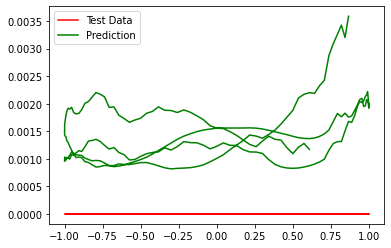

In [77]:
for batch in dataset_val.take(1):
    x, y = batch
    y_pred = model.predict(x)
    
    fig, ax = plt.subplots()
   
    time = x[0:, 89, 20]
    
    print(df_norm[20][564551])
    print(time[1])
    
    time = time * train_std[20] + train_mean[20]
    
    print(data['Day cos'][564551])
    print(time[1])
        
    timestamp = np.arccos(time) / (2 * np.pi / day)
    
    print("data: ", data['Day cos'][564551])
    print("timestamp: ", timestamp_s[564551])
    print("day: ", day)
    print("times calculado: ",timestamp[1])
    
    print(datetime.fromtimestamp(timestamp[1]))
    print(data.index[564551])
    
    ax.plot(time, y[0:], c='r', label="Test Data")
    ax.plot(time, (y_pred[0:]),c='g', label="Prediction")
    plt.legend()
    plt.show()